<a href="https://colab.research.google.com/github/chenyu313/Colaboratory_note/blob/main/colab%E7%9A%84%E4%B8%80%E4%BA%9B%E5%B0%8F%E6%8A%80%E5%B7%A7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 一、初始设置
## 1.占用显存
首先输入命令，占用1个G的显存，让谷歌认为你没有滥用显存。

In [ ]:
import torch
a = torch.Tensor([1000, 1000, 1000]).cuda()  # 大约占用 1.1G 显存

## 2.查看分配给自己的显卡


In [ ]:
!nvidia-smi

Fri Feb 24 03:22:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    30W /  70W |    570MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 二、训练部分
## 1.挂载google drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## 2.更改工作目录
可以将工作路径更改  
import os  
os.chdir("更改后的路径")   

## 3.移动训练数据
训练数据最好复制一份到服务器里，训练数据最好复制一份到服务器里。 


```
!cp /content/drive/具体训练数据地址 /content   
!unzip -d /content/centernet
```
如下： 

```
!cp /content/drive/Shareddrives/deeplearning_data/centernet-pytorch.zip /content 
!unzip -d /content/centernet
```



  

## 4.开始训练

In [ ]:
!python train.py

## 5.防止断连
* 方法一：每60分钟自动运行代码刷新，解除90分钟断开限制. 使用方法：colab页面按F12或者 Ctrl+Shift+I (mac按 Option+Command+I) 在console（控制台） 输入以下代码并回车. 复制以下代码粘贴在浏览器console！！不要关闭浏览器以免失效


```
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
```
* 方法二：安装浏览器插件Colab Alive

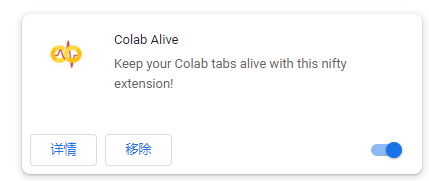


## 6.如何加断点存储模型参数
每个epoch都用torch.save()存储一下模型参数。然后重新训练时加载模型选择相应的pth模型参数即可。  
由于Colab随时有可能断开连接，在Colab上训练模型的代码必须要有可恢复性（能载入上一次训练的结果）。两个分别实现保存和加载checkpoint的函数附在下方（基于pytorch）。


```
def save_checkpoint(path: Text,
          epoch: int,
          modules: Union[nn.Module, Sequence[nn.Module]],
          optimizers: Union[opt.Optimizer, Sequence[opt.Optimizer]],
          safe_replacement: bool = True):

    """
    保存当前训练状态的检查点，以便可以恢复。

    这个检查点函数假设没有用于自动混合精度的学习率调度器或梯度缩放器。
    :param path:
        检查点文件路径
    :param epoch:
        当前(已完成)epoch
    :param modules:
        包含模型或模块对象列表的模块
    :param optimizers:
        优化器或优化器列表
    :param safe_replacement:
        保留旧的检查点，直到新的检查点完成
    :return:
    """

#此函数可以被称为
#save_checkpoint('/my/checkpoint/path.pth', my_epoch, my_module, my_opt)
#或
#save_checkpoint('/my/checkpoint/path.pth', my_epoch, [my_module1, my_module2], [my_opt1, my_opt2])

    if isinstance(modules, nn.Module):
        modules = [modules]
    if isinstance(optimizers, opt.Optimizer):
        optimizers = [optimizers]

#待保存的数据字典
    data = {
        'epoch': epoch,
        # Current time (UNIX timestamp)
        'time': time.time(),
        # State dict for all the modules
        'modules': [m.state_dict() for m in modules],
        # State dict for all the optimizers
        'optimizers': [o.state_dict() for o in optimizers]
    }
#安全更换旧检查点
    temp_file = None
    if os.path.exists(path) and safe_replacement:
        # There's an old checkpoint. Rename it!
        temp_file = path + '.old'
        os.rename(path, temp_file)
#保存新的检查点
    with open(path, 'wb') as fp:
        torch.save(data, fp)
        # Flush and sync the FS
        fp.flush()
        os.fsync(fp.fileno())
#删除久的检查点
    if temp_file is not None:
        os.unlink(path + '.old')

def load_checkpoint(path: Text,
          default_epoch: int,
          modules: Union[nn.Module, Sequence[nn.Module]],
          optimizers: Union[opt.Optimizer, Sequence[opt.Optimizer]],
          verbose: bool = True):
    """
    尝试加载一个检查点以恢复训练。
    :param path:
        检查点文件的路径
    :param default_epoch:
        “epoch”的初始值(以防没有快照)
    :param modules:
        包含模型或模块对象列表的模块。它们被假定停留在同一设备上
    :param optimizers:
        优化器或优化器列表
    :param verbose:
        详细模式
    :return:
        Next epoch
    """
    if isinstance(modules, nn.Module):
        modules = [modules]
    if isinstance(optimizers, opt.Optimizer):
        optimizers = [optimizers]

    # 如果有检查点的话
    if os.path.exists(path):
        # 加载数据
        data = torch.load(path, map_location=next(modules[0].parameters()).device)

        # 通知用户我们正在加载检查点
        if verbose:
            print(f"Loaded checkpoint saved at {datetime.fromtimestamp(data['time']).strftime('%Y-%m-%d %H:%M:%S')}. "
                  f"Resuming from epoch {data['epoch']}")

        # 所有模块的加载状态
        for i, m in enumerate(modules):
            modules[i].load_state_dict(data['modules'][i])

        # 所有优化器的加载状态
        for i, o in enumerate(optimizers):
            optimizers[i].load_state_dict(data['optimizers'][i])

        # Next epoch
        return data['epoch'] + 1
    else:
        return default_epoch
```



在主程序train.py正式训练前，添加下面的语句：


```
if args.resume: # args.resume是命令行输入的参数，用于指示要不要加载上次训练的结果
    first_epoch = load_checkpoint(checkpoint_path, first_epoch, net_list, optims_list)
```



在每个epoch训练结束后，保存checkpoint：


```
# Save checkpoint
 save_checkpoint(checkpoint_path, epoch, net_list, optims_list)
```
net_list是需要保存的网络列表，optims_list是需要保存的优化器列表

这里没有记录scheduler的列表，如果代码里用到了scheduler，那也要保存scheduler的列表。


## 参考文章
https://zhuanlan.zhihu.com/p/387509768  
https://zhuanlan.zhihu.com/p/527663163